In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transform

import dataloader 
from transforms import mulawnEncode,mulaw,array2tensor,dic2tensor
from paramManager import paramManager

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

In [3]:
# Read/write directory parameters
#*************************************
datadir = 'dataset'
paramdir = 'dataparam'

# Training parameters
#*************************************
sr = 16000
seqLen = 256
stride = 10
batch_size = 25
num_epochs = 1
lr = 0.005
log_interval = 20
max_steps = 1000

In [4]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(datadir, paramdir)
datafiles = pm.filenames(datadir)
params = pm.getParams(datafiles[0]) 
print(params.keys())

#note midiPitch has to be scaled since the large raw values interfere with the learning

dict_keys(['meta', 'rmse', 'instID', 'midiPitch'])


In [5]:
# Initialize dataset & dataloader
#*************************************
adataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension="wav",
                                  paramdir=paramdir,prop=['instID'],  #,'midiPitch'
                                  transform=transform.Compose([mulawnEncode(256,0,1),array2tensor(torch.FloatTensor)]),
                                  param_transform=dic2tensor(torch.FloatTensor),
                                  target_transform=transform.Compose([mulaw(256),array2tensor(torch.LongTensor)]))

train_loader = torch.utils.data.DataLoader(dataset=adataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=4)

In [ ]:
#just for testing

for i in range(len(adataset)):
    sample,target = adataset[i]
    #plt.plot(sample['audio'])
    #for param in sample:
    #    print(param)
    print(sample)
    print(target)
    if i == 1:
        break #just to visualize, note: audio is already mu-lawed
        
print(len(adataset))
print(adataset.totalSamples)
#input dim: (batch, seq, feature)

In [9]:
# Specify the model
#*************************************
class RNN(nn.Module):
    # input size - the number of "classes"
    def __init__(self, input_size, cond_size, batch_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.cond_size = cond_size
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers #no. of stacked GRU layers

        self.i2h = nn.Linear(input_size+cond_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
    

    # input and cv are each one sequence element 
    def forward(self, input, hidden):
        #print("input size is " + str((input.size())))
        
        h1 = self.i2h(input)
        #print("size of h1 is " + str(h1.size()))
        
        h_out, hidden = self.gru(h1.view(self.batch_size,1,-1), hidden)
        #print("h_out"+str(h_out.size()))
        
        output = self.decoder(h_out.view(self.batch_size, -1))
        #print("output2"+str(output.size()))
        
        return output, hidden

    # initialize hiddens for each minibatch
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, self.batch_size, self.hidden_size).type(torch.cuda.FloatTensor))

In [10]:
# Define the training cycle
#*************************************
def train(epoch):
    rnn.train() #put in training mode
    ave_loss_over_steps = 0
    
    for step, (inp,target) in enumerate(train_loader):
        #print('INP',inp.shape)
        #print("TAR",target.shape)
        inp, target = inp.cuda(), target.cuda()
        inp, target = Variable(inp), Variable(target)

        # Forward + Backward + Optimize
        hidden = rnn.init_hidden()
        optimizer.zero_grad()
        loss = 0
        
        for i in range(seqLen):
            outputs, hidden = rnn(inp[:,i,:],hidden)
            #print('target size',torch.squeeze(target[:,i],1).size())
            loss += criterion(outputs, torch.squeeze(target[:,i],1))
            
        loss.backward()
        optimizer.step()
        
        ave_loss_per_sample = loss.data[0]/seqLen   #over each minibatch
        ave_loss_over_steps += ave_loss_per_sample
        #print(count,ave_loss)
        
        if (step+1) % log_interval == 0:
            print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}'.format( 
                datetime.now(), epoch+1, num_epochs, step+1, len(adataset)//batch_size, ave_loss_over_steps/log_interval))
            
            list_of_losses.append(ave_loss_over_steps/log_interval)
            ave_loss_over_steps = 0
        
        if step==max_steps:
            break
        
        

In [11]:
# Initialize the network, optimizer and objective func
#*************************************
rnn = RNN(1,1,batch_size,40,256,4).cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [12]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(num_epochs):
    train(epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

2018-08-08 13:02:38 Starting training...


C:\Users\Huz\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


2018-08-08 13:02:54 Epoch [1/1], Step [20/15200] Loss: 5.2819
2018-08-08 13:03:07 Epoch [1/1], Step [40/15200] Loss: 5.1271
2018-08-08 13:03:20 Epoch [1/1], Step [60/15200] Loss: 5.1105
2018-08-08 13:03:33 Epoch [1/1], Step [80/15200] Loss: 4.9367
2018-08-08 13:03:46 Epoch [1/1], Step [100/15200] Loss: 4.5660
2018-08-08 13:03:59 Epoch [1/1], Step [120/15200] Loss: 4.2978
2018-08-08 13:04:12 Epoch [1/1], Step [140/15200] Loss: 4.0687
2018-08-08 13:04:25 Epoch [1/1], Step [160/15200] Loss: 3.9183
2018-08-08 13:04:38 Epoch [1/1], Step [180/15200] Loss: 3.8056
2018-08-08 13:04:51 Epoch [1/1], Step [200/15200] Loss: 3.7193
2018-08-08 13:05:05 Epoch [1/1], Step [220/15200] Loss: 3.6112
2018-08-08 13:05:18 Epoch [1/1], Step [240/15200] Loss: 3.5877
2018-08-08 13:05:31 Epoch [1/1], Step [260/15200] Loss: 3.6506
2018-08-08 13:05:44 Epoch [1/1], Step [280/15200] Loss: 3.5875
2018-08-08 13:05:57 Epoch [1/1], Step [300/15200] Loss: 3.5153
2018-08-08 13:06:10 Epoch [1/1], Step [320/15200] Loss: 3.4

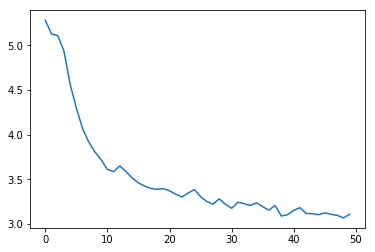

In [13]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)